# Multi-modality pipeline: analyzing single-cell multiome data (ATAC + Gene Expression)

## Introduction

In this tutorial we will analyze single-cell multiome data data from Peripheral blood mononuclear cells (PBMCs). The dataset used in this tutorial can be found here: http://renlab.sdsc.edu/kai/10x-Multiome/.

In addition to SnapATAC2, we will utilize [scanpy](https://scanpy.readthedocs.io/en/stable/) and [scglue](https://scglue.readthedocs.io/en/latest/index.html) to perform the integration.

In [1]:
import scanpy as sc
import snapatac2 as snap
import anndata as ad
import scglue
import itertools

## Analyze gene expression data

In [2]:
rna = sc.read_h5ad("10x-Multiome-Pbmc10k-RNA.h5ad")
rna

AnnData object with n_obs × n_vars = 9631 × 29095
    obs: 'domain', 'cell_type'
    var: 'gene_ids', 'feature_types'

First we backup the raw counts in anndata and perform the preprocessing.

In [3]:
rna.layers["counts"] = rna.X.copy()
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna)
rna = rna[:, rna.var.highly_variable]
sc.pp.scale(rna, max_value=10)

/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


We then perform the dimension reduction, followed by UMAP embedding.

In [4]:
sc.tl.pca(rna)
sc.pp.neighbors(rna)
sc.tl.umap(rna)

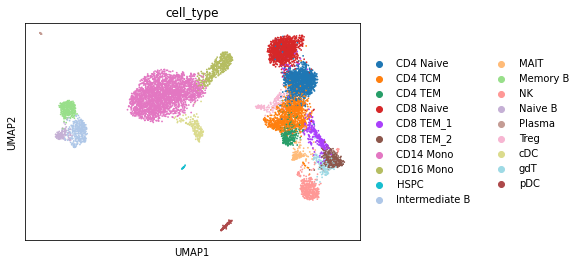

In [5]:
sc.pl.umap(rna, color="cell_type")

## Analyze chromatin accessibility data

In [6]:
atac = snap.read("10x-Multiome-Pbmc10k-ATAC.h5ad")
atac

AnnData object with n_obs x n_vars = 9631 x 107194 backed at '10x-Multiome-Pbmc10k-ATAC.h5ad'
    obs: cells, domain, cell_type
    var: peaks, feature_types
    obsm: X_umap, X_spectral
    uns: spectral_eigenvalue

In [7]:
snap.tl.spectral(atac, features=None, n_comps=30)
snap.tl.umap(atac)

Compute similarity matrix
Normalization
Perform decomposition


/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/polars/internals/frame.py:1675: UserWarning: setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column
  warnings.warn(


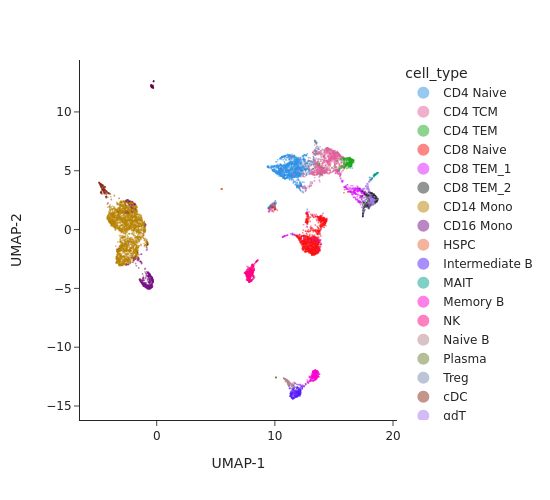

In [8]:
snap.pl.umap(atac, color="cell_type", interactive = False)

In [9]:
atac.close()

## Perform data integration

First we need to assign genomic coordinates to the genes in scRNA-seq experiment. To do this, we need to download gene annotations from [here](https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_40/gencode.v40.chr_patch_hapl_scaff.annotation.gtf.gz).

In [10]:
scglue.data.get_gene_annotation(
    rna, gtf="gencode.v40.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna = rna[:, rna.var.dropna().index.to_numpy()]
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

chrom  chromStart    chromEnd
genes                                 
MEGF6     chr1   3487950.0   3611508.0
TNFRSF25  chr1   6460785.0   6466175.0
CAMTA1    chr1   6785453.0   7769706.0
SLC25A33  chr1   9539464.0   9585173.0
DHRS3     chr1  12567909.0  12618210.0

In [11]:
atac = ad.read("10x-Multiome-Pbmc10k-ATAC.h5ad")
sc.pp.neighbors(atac, use_rep="X_spectral")
atac

AnnData object with n_obs × n_vars = 9631 × 107194
    obs: 'domain', 'cell_type'
    var: 'feature_types'
    uns: 'spectral_eigenvalue', 'neighbors'
    obsm: 'X_spectral', 'X_umap'
    obsp: 'distances', 'connectivities'

In [12]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1])
atac.var["chromEnd"] = split.map(lambda x: x[2])
atac.var.head()

feature_types chrom chromStart chromEnd
peaks                                                     
chr1:816881-817647         Peaks  chr1     816881   817647
chr1:819912-823500         Peaks  chr1     819912   823500
chr1:825827-825889         Peaks  chr1     825827   825889
chr1:826612-827979         Peaks  chr1     826612   827979
chr1:841243-843059         Peaks  chr1     841243   843059

In [13]:
graph = scglue.genomics.rna_anchored_prior_graph(rna, atac)
graph

  0%|          | 0/1334 [00:00<?, ?it/s]

In [14]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)

scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_spectral"
)

/home/kaizhang/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



In [15]:
graph = graph.subgraph(itertools.chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
))

In [16]:
# This is patch for numpy >= 1.21 to fix a bug mentioned in
# https://github.com/lmcinnes/pynndescent/issues/163
import pynndescent
import numba
import numpy as np
@numba.njit(fastmath=True)
def correct_alternative_cosine(ds):
    result = np.empty_like(ds)
    for i in range(ds.shape[0]):
        result[i] = 1.0 - np.power(2.0, ds[i])
    return result
pynn_dist_fns_fda = pynndescent.distances.fast_distance_alternatives
pynn_dist_fns_fda["cosine"]["correction"] = correct_alternative_cosine
pynn_dist_fns_fda["dot"]["correction"] = correct_alternative_cosine

We now start training the model.

In [17]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, graph,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] autodevice: Using GPU 4 as computation device.
[INFO] SCGLUEModel: Setting `graph_batch_size` = 12615
[INFO] SCGLUEModel: Setting `max_epochs` = 178
[INFO] SCGLUEModel: Setting `patience` = 15
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"


/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/torch/distributions/negative_binomial.py:97: UserWarning:

Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/kaizhang/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)



[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.515, 'g_kl': 0.016, 'g_elbo': 0.53, 'x_rna_nll': 0.428, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.437, 'x_atac_nll': 0.282, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.283, 'dsc_loss': 0.689, 'vae_loss': 0.742, 'gen_loss': 0.707}, val={'g_nll': 0.513, 'g_kl': 0.016, 'g_elbo': 0.529, 'x_rna_nll': 0.433, 'x_rna_kl': 0.01, 'x_rna_elbo': 0.443, 'x_atac_nll': 0.279, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.28, 'dsc_loss': 0.69, 'vae_loss': 0.744, 'gen_loss': 0.71}, 4.7s elapsed
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.483, 'g_kl': 0.015, 'g_elbo': 0.498, 'x_rna_nll': 0.425, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.434, 'x_atac_nll': 0.277, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.278, 'dsc_loss': 0.688, 'vae_loss': 0.733, 'gen_loss': 0.698}, val={'g_nll': 0.482, 'g_kl': 0.015, 'g_elbo': 0.497, 'x_rna_nll': 0.427, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.436, 'x_atac_nll': 0.276, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.278, 'dsc_loss': 0.69, 'vae_loss': 0.734, 'gen_lo

2022-06-25 12:44:53,779 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "56"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (17, 16)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] SCGLUEModel: Setting `graph_batch_size` = 12615
[INFO] SCGLUEModel: Setting `align_burnin` = 30
[INFO] SCGLUEModel: Setting `max_epochs` = 178
[INFO] SCGLUEModel: Setting `patience` = 15
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.472, 'g_kl': 0.015, 'g_elbo': 0.486, 'x_rna_nll': 0.424, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.432, 'x_atac_nll': 0.277, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.279, 'dsc_loss': 0.691, 'vae_loss': 0.73, 'gen_loss': 0.696}, val={'g_nll': 0.472, 'g_kl': 0.015, 'g_elbo': 0.487, 'x_rna_nll': 0.43, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.439, 'x_atac_nll': 0.275, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.277, 'dsc_loss': 0.691, 'vae_loss': 0.735, 'gen_loss': 0.701}, 4.4s elapsed
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.469, 'g_kl': 0.014, 'g_elbo': 0.483, 'x_rna_nll': 0.424, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.432, 'x_atac_nll': 0.276, 'x_at

2022-06-25 12:55:43,212 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "56"...


In [18]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [19]:
combined = ad.concat([rna, atac])
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)

/home/kaizhang/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



In [20]:
sc.pl.umap(combined, color=["cell_type", "domain"], wspace=0.45)